In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ECHO
from ECHO.read_utils import read_ulog, read_tlog_txt
from glob import glob
import healpy as hp
import pandas as pd
import glob
import os
import pytz 
from scipy.interpolate import interp1d
from astropy.time import Time
from ECHO.plot_utils import grid_to_healpix, make_polycoll,project_healpix,fmt,nf,cmap_discretize,get_interp_val
from ECHO.position_utils import latlon2xy,to_spherical
from matplotlib import ticker,cm

In [2]:
rxdir = '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data/'
logdir = '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_Flightlogs/Map1/'

In [3]:
def read_fieldfox(file):
    data = np.array(pd.read_csv(file,skiprows = 32))
    freq = data[:-1,0].astype(float)
    power= data[:-1,1].astype(float)
    return freq, power

In [4]:
background_freq, background_power = read_fieldfox(rxdir+ '9.May.2021.Background.csv')

<IPython.core.display.Javascript object>


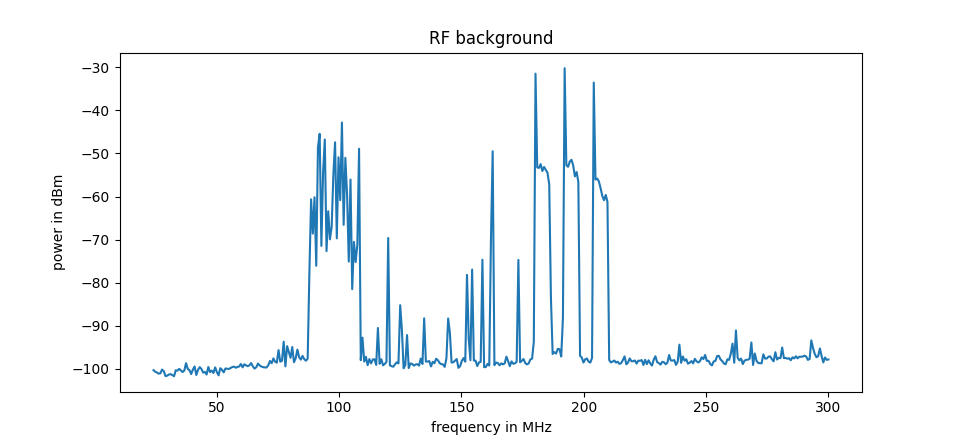

Text(0.5, 1.0, 'RF background')

In [5]:
plt.figure()
plt.plot(background_freq/1e6, background_power)
plt.xlabel('frequency in MHz')
plt.ylabel('power in dBm')
plt.title('RF background')

In [ ]:
os.listdir(logdir)

In [ ]:
help(ECHO.read_utils.read_ulog)

In [ ]:
help(ECHO.read_utils.read_tlog_txt)

In [6]:
global_arr, local_arr, gps_arr = read_ulog(logdir +'log_2_2021-5-9-07-58-54.ulg')

<IPython.core.display.Javascript object>


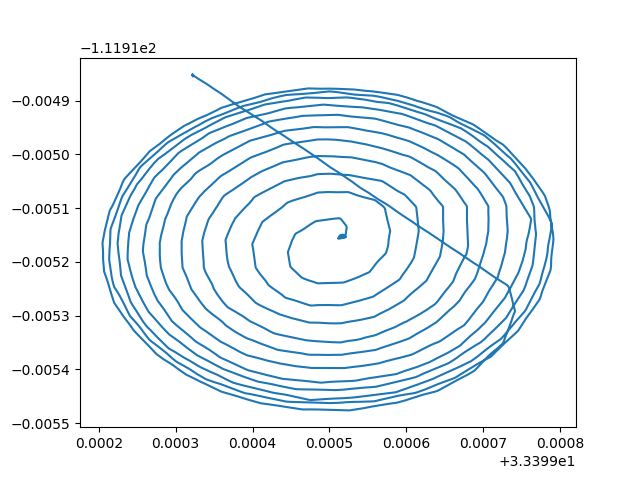

In [7]:
plt.figure()
plt.plot(global_arr[:,1], global_arr[:,2])

In [8]:
bootstart = gps_arr[0][1]-gps_arr[0][0]
global_arr[:,0] = global_arr[:,0]+ bootstart
local_arr[:,0] = local_arr[:,0]+bootstart
local_arr = np.delete(local_arr,1,1)
gps_arr[:,0] = gps_arr[:,0]+bootstart
gps_arr = np.delete(gps_arr,1,1)

In [9]:
ulog_times = Time(global_arr[:,0], format= 'unix', scale = 'utc')
ulog_times[0].iso, ulog_times[-1].iso

('2021-05-09 14:31:01.457', '2021-05-09 14:58:54.857')

<IPython.core.display.Javascript object>


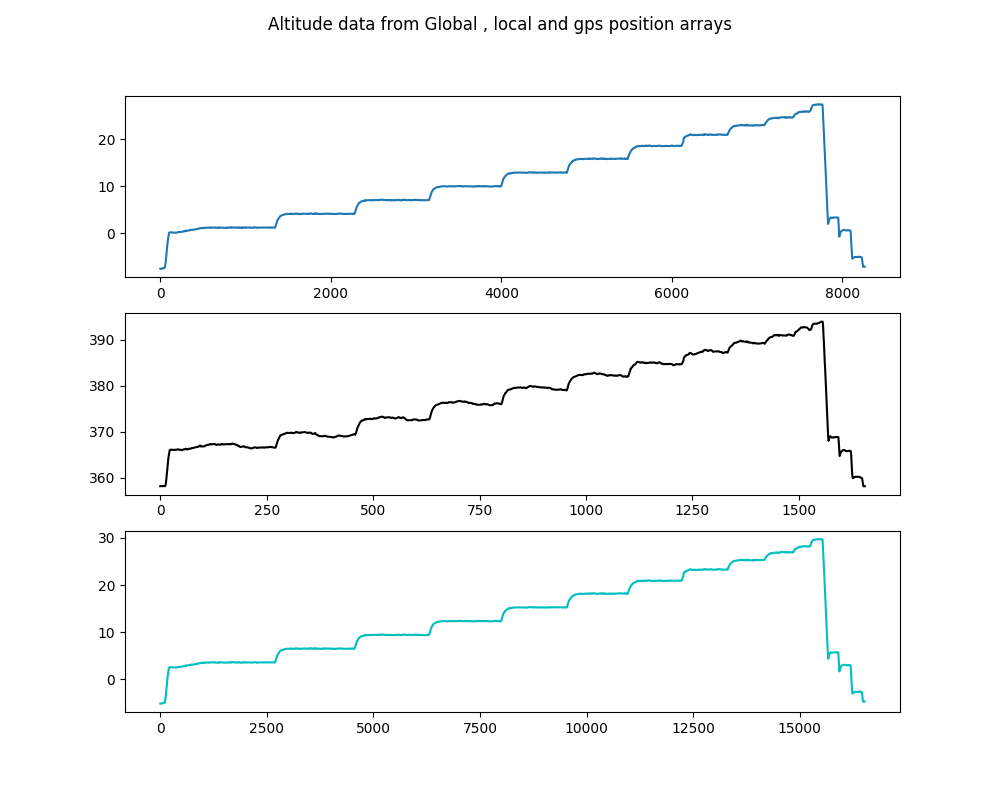

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(3, figsize= (10,8))
fig.suptitle('Altitude data from Global , local and gps position arrays')
ax1.plot(global_arr[:,3]+1125) #alts off by a factor of 1125
ax2.plot(gps_arr[:,-1],'k')
ax3.plot(local_arr[:,5], 'c')

In [11]:
wp_arr, global_arr_t, local_arr_t, gps_arr_t = read_tlog_txt(logdir + '2021-05-09 08-08-07.txt')

In [ ]:
plt.figure()
plt.plot(wp_arr[:,1])

In [12]:
tlog_times = Time(global_arr_t[:,0], format = 'unix', scale = 'utc')
tlog_times[0].iso, tlog_times[-1].iso

('2021-05-09 14:01:04.000', '2021-05-09 15:06:04.000')

### Tlog headers

global_t headers: #time(s from epoch)    lat(deg)    lon(deg)    alt(m above ground)    hdg(deg)

local_t headers: #time(s from epoch)    x(m)    y(m)    z(m above ground)

gps_t headers: #time(s from epoch)    lat(deg)    lon(deg)    alt(m above sea)

In [13]:
global_arr_t[:,0] = global_arr_t[:,1]+ bootstart
global_arr_t = np.delete(global_arr_t,1,1)
local_arr_t[:,0] = local_arr_t[:,1]+ bootstart
local_arr_t = np.delete(local_arr_t,1,1)
gps_arr_t[:,0] = gps_arr_t[:,1]+ bootstart
gps_arr_t = np.delete(gps_arr_t,1,1)

In [ ]:
Time(wp_arr, format = 'unix').iso

<IPython.core.display.Javascript object>


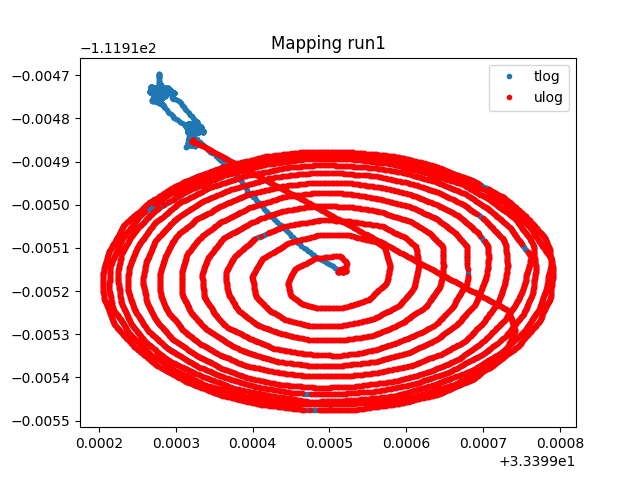

Text(0.5, 1.0, 'Mapping run1')

In [14]:
plt.figure()
#plt.plot(global_arr_t[:,3])
plt.plot(global_arr_t[:,1], global_arr_t[:,2], '.', label = 'tlog')
plt.plot(global_arr[:,1], global_arr[:,2], '.', color = 'r', label = 'ulog')
plt.legend()
plt.title('Mapping run1')

In [15]:
def mission_endpoint_flagging(pos_data,wpt_data):
    flagged_indices = []
    mission_indices = []
    mission_start = 0
    mission_end = wpt_data[-1][0]
    
    for row in wpt_data:
        if row[1] == 1:
            mission_start = row[0]
            break
    
    for index,row in enumerate(pos_data):
        if row[0]<mission_start or row[0]>mission_end: flagged_indices.append(index)
        else: mission_indices.append(index)
    
    flagged_data = np.delete(pos_data,mission_indices,0)
    mission_data = np.delete(pos_data,flagged_indices,0)
    return flagged_data, mission_data

In [16]:
flagged_drone_pos, drone_pos_t = mission_endpoint_flagging(global_arr_t, wp_arr)

<IPython.core.display.Javascript object>


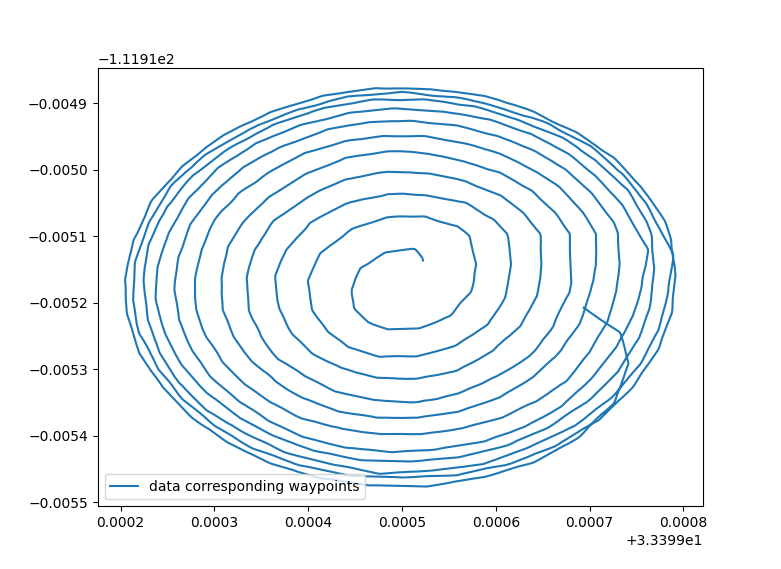

In [18]:
plt.figure()
#plt.plot(flagged_drone_pos[:,3], label = 'flagged')
plt.plot(drone_pos_t[:,1], drone_pos_t[:,2], label = 'data corresponding waypoints')
plt.legend()

In [19]:
rx_files = glob.glob(rxdir + '/Mapping_run1/*.csv')
rx_files

['/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/0.csv',
 '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/1.csv',
 '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/2.csv',
 '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/3.csv',
 '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/4.csv',
 '/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/5.csv']

In [20]:
final_df = []
for file in rx_files:
    print(file)
    data = pd.read_csv(file,skiprows = 17,header=None)
    data=data.drop([0,2,3,4],axis=1)
    with open(file,'r') as f:
        for i,line in enumerate(f):
            if 'Freq Hz' in line:
                break
    cols=line.split(',')[5:]
    cols = ['Datetime'] + cols
    data.columns=cols
    final_df.append(data)

/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/0.csv


/home/mrudula/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/1.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/2.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/3.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/4.csv
/media/sf_Dropbox_ASU/ECHO/MWA_dipole_measurements/9_May_2021_third_attempt/9_May_2021_FF_data//Mapping_run1/5.csv


In [21]:
rx_data = pd.concat(final_df,ignore_index=True)
rx_data['Datetime'] = pd.to_datetime(rx_data['Datetime'])

<IPython.core.display.Javascript object>


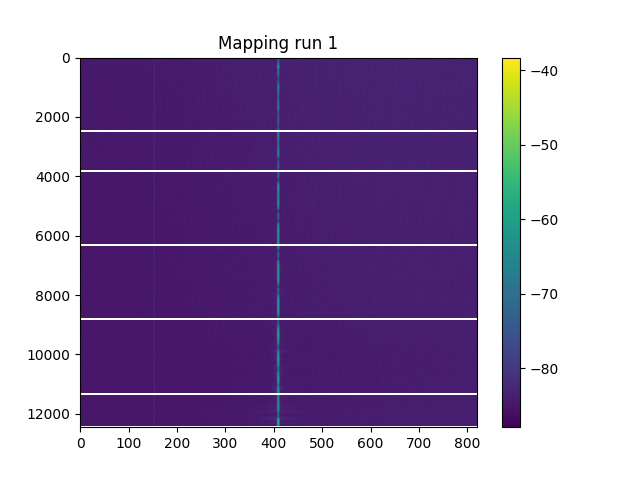

In [22]:
plt.figure()
plt.imshow(rx_data.iloc[:,2:], aspect = 'auto')
plt.title('Mapping run 1')
plt.colorbar()

In [23]:
rx_times = rx_data['Datetime'].dt.tz_localize('US/Arizona').dt.tz_convert('utc')
temp_df = pd.DataFrame({'a':range(drone_pos_t.shape[0])})
temp_df['date'] = drone_pos_t[:,0]
temp_df['date'] = pd.to_datetime(temp_df['date'],unit='s')
drone_times = temp_df['date'].dt.tz_localize('utc')

In [ ]:
rx_times.values

In [ ]:
#rx_data.iloc[2000,:].values[1:]

<IPython.core.display.Javascript object>


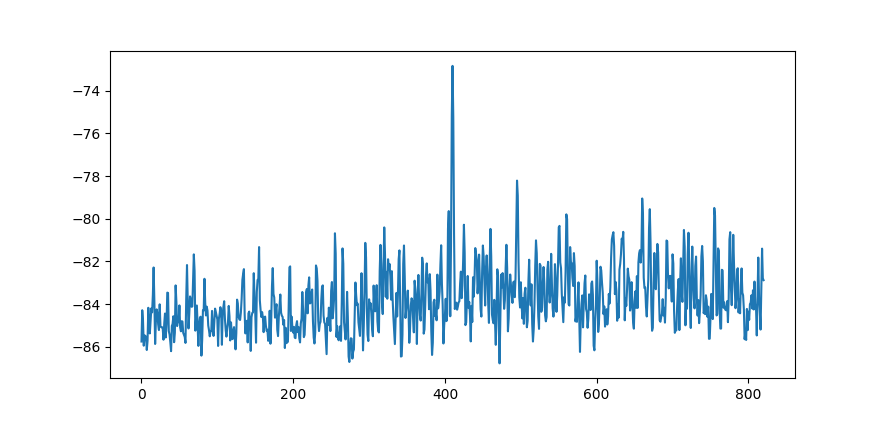

In [24]:
plt.figure()
plt.plot(rx_data.iloc[2000,:].values[1:])

<IPython.core.display.Javascript object>


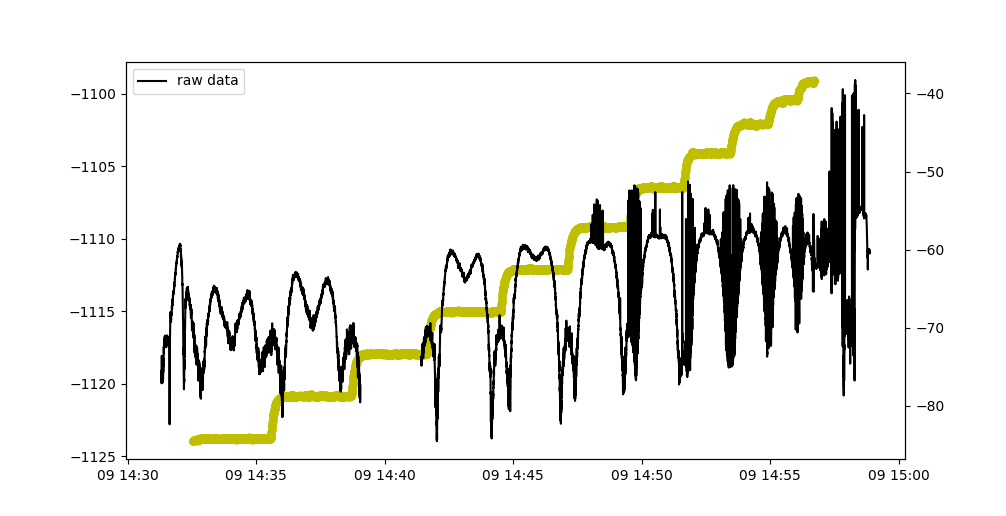

In [34]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(drone_times, drone_pos_t[:,3], 'y', marker = 'o', markersize = 5,label = 'mission altitude' )
#ax2.plot(tlog_times.datetime64, global_arr_t[:,1])
ax2.plot(rx_times.values,rx_data.iloc[:,411].values, 'k', label = 'raw data')
plt.legend()

In [28]:
mission_rx = rx_data[(rx_times >= drone_times.iloc[0]) & 
                     (rx_times <= drone_times.iloc[-1])]

<IPython.core.display.Javascript object>


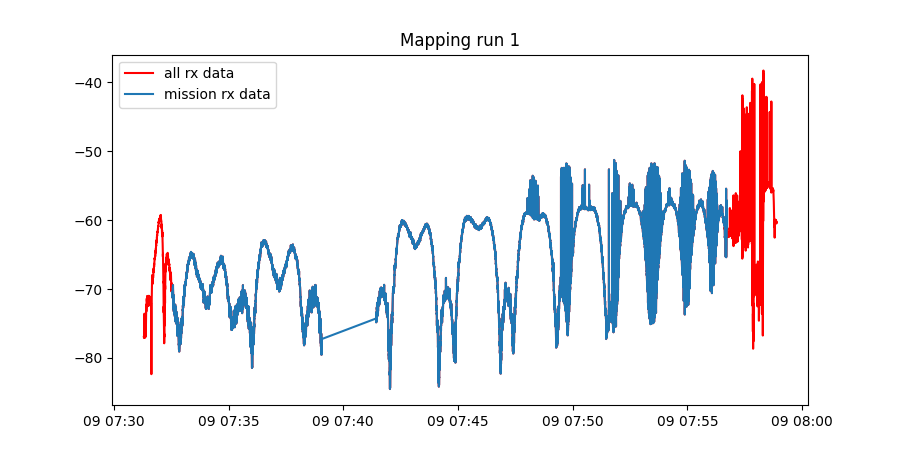

In [29]:
plt.figure()
plt.plot(rx_data['Datetime'],rx_data.iloc[:,411], 'r', label = 'all rx data')
plt.plot(mission_rx['Datetime'],mission_rx.iloc[:,411], label ='mission rx data' )
plt.title('Mapping run 1')
plt.legend()

<IPython.core.display.Javascript object>


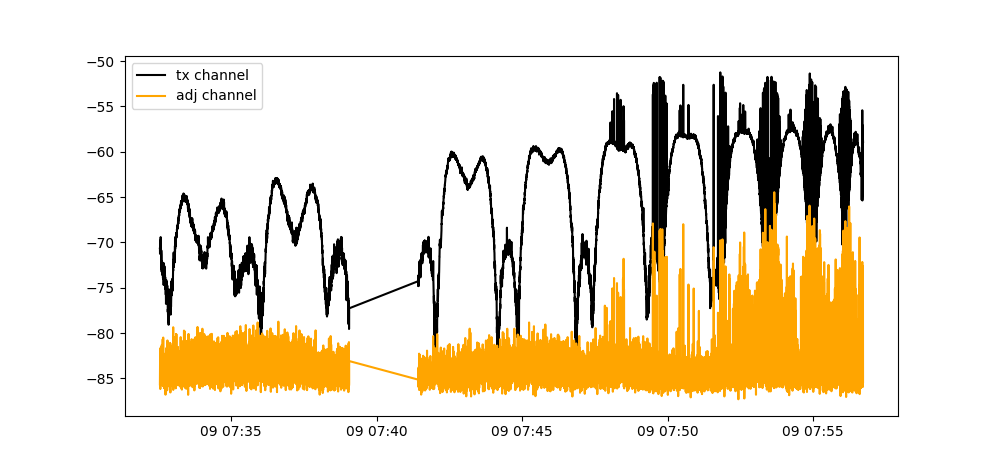

In [32]:
plt.figure()

icicles = rx_data.iloc[:,411]-rx_data.iloc[:,410]
plt.plot(mission_rx['Datetime'],mission_rx.iloc[:,411], 'k', label = 'tx channel')
#plt.plot(rx_data['Datetime'],rx_data.iloc[:,410],'r')
plt.plot(mission_rx['Datetime'],mission_rx.iloc[:,407], 'orange', label = 'adj channel')
plt.legend()
#plt.plot(rx_data['Datetime'],rx_data.iloc[:,300], 'y')
#plt.plot(rx_data['Datetime'],rx_data.iloc[:,411]-icicles, 'blue')